# Pneumonia Model Comparison – ResNet50 vs VGG16

This notebook loads the trained models, evaluates both on the test set, and visualizes metrics side-by-side. It saves comparison tables and plots to `results/`.


In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(tf.__version__)


2.20.0


In [2]:
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data" / "chest_xray"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

resnet_path = MODELS_DIR / "resnet50_final.h5"
vgg_path = MODELS_DIR / "vgg16_final.h5"

for p in [resnet_path, vgg_path]:
    if not p.exists():
        raise FileNotFoundError(f"Model file missing: {p}. Train models first.")

if not DATA_DIR.exists():
    raise FileNotFoundError("Dataset not found at data/chest_xray.")

print("Paths ready")


Paths ready


In [3]:
# Test data generator (no shuffle to align labels)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_dir = DATA_DIR / "test"

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
    seed=SEED,
)

true_labels = test_generator.classes
print(f"Test samples: {len(true_labels)}")


Found 624 images belonging to 2 classes.
Test samples: 624


In [4]:
def evaluate_model(model_path, name):
    print(f"Loading {name} from {model_path}")
    model = load_model(model_path)
    steps = test_generator.samples // BATCH_SIZE
    probs = model.predict(test_generator, steps=steps + 1, verbose=1).ravel()
    preds = (probs >= 0.5).astype(int)[: len(true_labels)]

    acc = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average="binary", zero_division=0)
    cm = confusion_matrix(true_labels, preds)

    return {
        "name": name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm,
    }

results = []
for model_name, path in [("ResNet50", resnet_path), ("VGG16", vgg_path)]:
    results.append(evaluate_model(path, model_name))

results_df = pd.DataFrame([{k: v for k, v in r.items() if k != "confusion_matrix"} for r in results])
print(results_df)

results_csv = RESULTS_DIR / "model_comparison_metrics.csv"
results_df.to_csv(results_csv, index=False)
print(f"Saved metrics table to {results_csv}")


Loading ResNet50 from c:\Users\jason\OneDrive\Desktop\CECS456Proj\models\resnet50_final.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 637ms/step


Loading VGG16 from c:\Users\jason\OneDrive\Desktop\CECS456Proj\models\vgg16_final.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
       name  accuracy  precision    recall  f1_score
0  ResNet50  0.625000   0.625000  1.000000  0.769231
1     VGG16  0.826923   0.814732  0.935897  0.871122
Saved metrics table to c:\Users\jason\OneDrive\Desktop\CECS456Proj\results\model_comparison_metrics.csv


Saved comparison plot to c:\Users\jason\OneDrive\Desktop\CECS456Proj\results\model_comparison_metrics.png


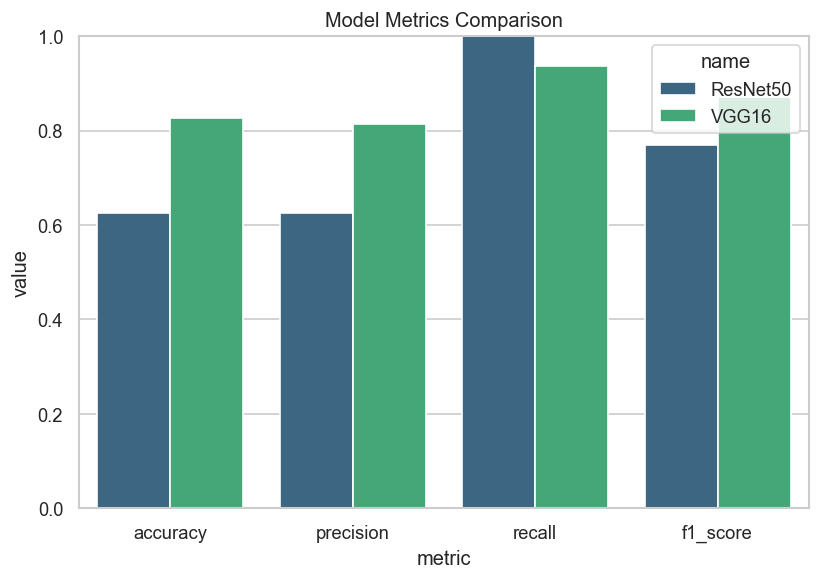

Saved confusion matrix comparison to c:\Users\jason\OneDrive\Desktop\CECS456Proj\results\model_comparison_confusion_matrices.png


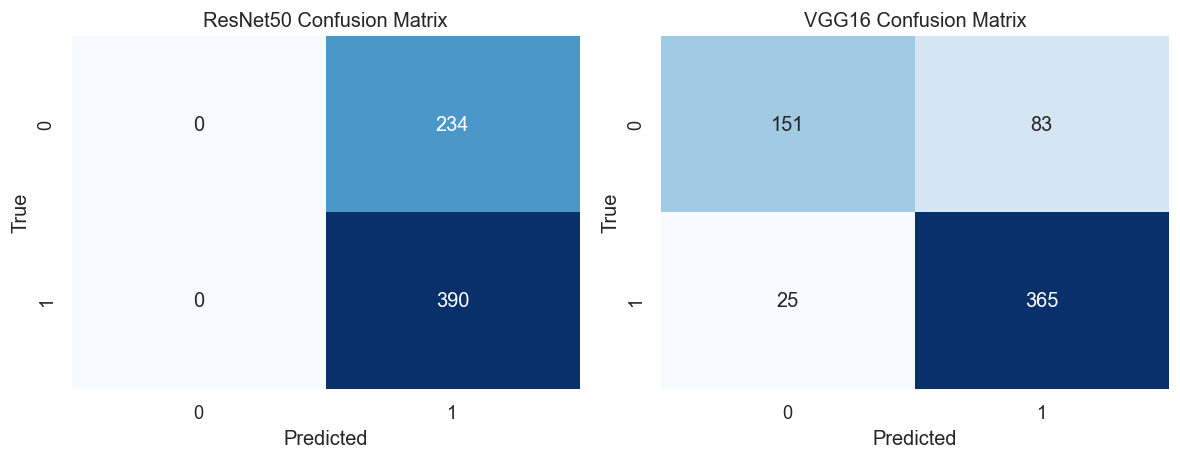

Saved metrics JSON to c:\Users\jason\OneDrive\Desktop\CECS456Proj\results\model_comparison_metrics.json


In [5]:
# Plot bar charts for metrics
melted = results_df.melt(id_vars="name", var_name="metric", value_name="value")
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=melted, x="metric", y="value", hue="name", palette="viridis", ax=ax)
ax.set_ylim(0, 1)
ax.set_title("Model Metrics Comparison")
plt.tight_layout()
plot_path = RESULTS_DIR / "model_comparison_metrics.png"
plt.savefig(plot_path, dpi=300)
print(f"Saved comparison plot to {plot_path}")
plt.show()

# Confusion matrices side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, res in zip(axes, results):
    sns.heatmap(res["confusion_matrix"], annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"{res['name']} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
cm_path = RESULTS_DIR / "model_comparison_confusion_matrices.png"
plt.savefig(cm_path, dpi=300)
print(f"Saved confusion matrix comparison to {cm_path}")
plt.show()

# Save JSON for quick reference
json_path = RESULTS_DIR / "model_comparison_metrics.json"
with open(json_path, "w") as f:
    json.dump(results_df.to_dict(orient="records"), f, indent=2)
print(f"Saved metrics JSON to {json_path}")
